In [1]:
%load_ext autoreload
%autoreload 2
# %config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json

using vice version  1.4.0.dev2


/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/__init__.py:151: UserWarning: Using a pre-release of VICE
  if prerelease: warnings.warn("Using a pre-release of VICE",


In [3]:
import surp.analysis.gas_phase_data as gap
import surp.analysis.apogee_analysis as aah
from surp.analysis.vice_model import vice_model
from surp import yields

import arya

In [6]:
all_abundances = pd.read_csv("all_data.csv")

subgiants = aah.subgiants
filt = ~np.isnan(subgiants["C_MG"])
filt &= ~np.isnan(subgiants["MG_H"])
filt &= subgiants["high_alpha"]
subgiants = subgiants[filt]

fiducial = vice_model("../../out/C11_f0.2_j8.json")

In [7]:
yields.set_yields()

Yield settings
X       CC                            agb                           SN Ia
c       4.00e-03 + 1.02e-01 (Z - Z0)  2.38 × cristallo11            0
n       7.20e-04                      0.00e+00 M + 9.00e-04 M Z/Z0  0
o       1.50e-02                      2.38 × cristallo11            0
mg      1.85e-03                      2.38 × cristallo11            0
fe      1.20e-03                      cristallo11                   1.70e-03




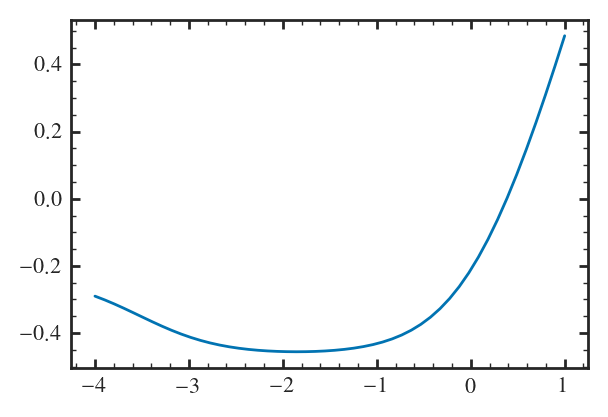

In [28]:
def y_cc_c(Z):
    return yields.C_CC_model(0.12, 0.0038, pop_iii=0.2)(Z)

    
MoverH = np.linspace(-4, 1)
plt.plot(MoverH, np.log10(y_cc_c(0.014*10**MoverH)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o")))

Text(0, 0.5, '[C/Mg]')

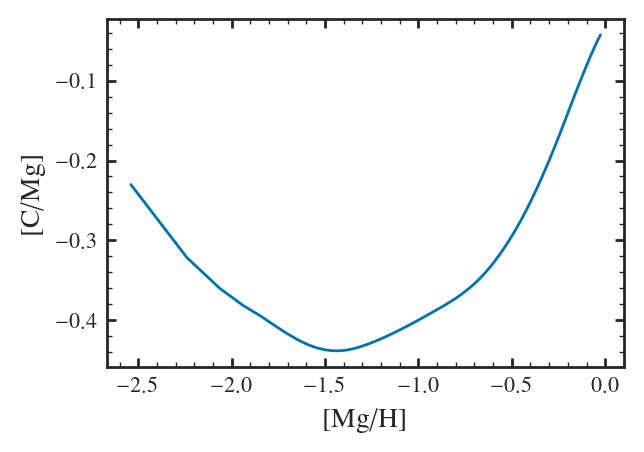

In [31]:
def sfh(t):
    return np.exp(-t/2)

vice.yields.ccsne.settings["c"] = y_cc_c
sz = vice.singlezone(elements=["o", "mg", "c", "fe"], dt=0.01, eta=6, func=sfh, mode="sfr", tau_star=9)
out = sz.run(np.arange(0, 6, 0.01), capture=True, overwrite=True)

plt.plot(out.history["[mg/h]"], out.history["[c/mg]"])
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

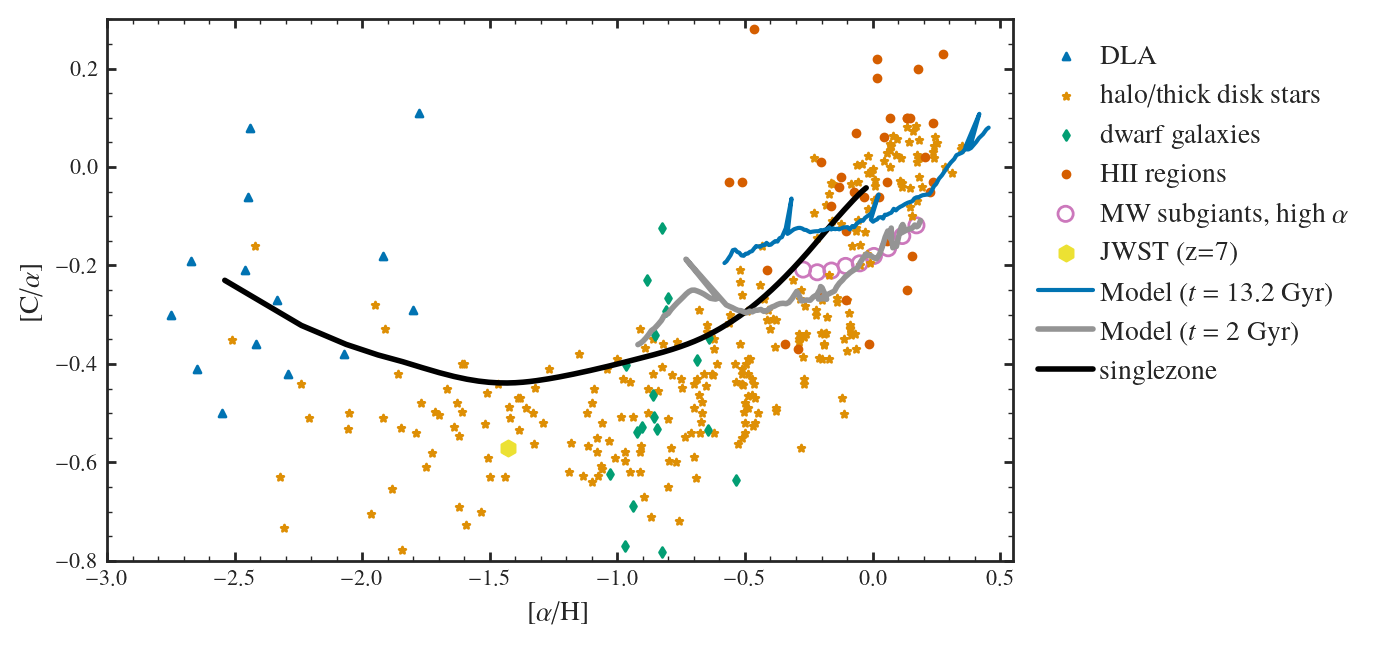

In [32]:
plt.figure(figsize=(7, 10/3))

for i in [3,2,1,0]:
    label = ["HII regions", "dwarf galaxies", "halo/thick disk stars", "DLA"][i]
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=label,
               marker=["o", "d", "*", "^"][i])
    
    



ha = subgiants["high_alpha"]
df = subgiants[ha]
arya.binnedplot(df, x="MG_H", y="C_MG", errorbar=None, binrange=(-0.3, 0.2), bins=10, stat="median", 
                edgecolor=arya.style.COLORS[4], facecolor='none', marker="o", s=30,
            zorder=-1, label="MW subgiants, high $\\alpha$")

plt.plot()

plt.ylim(-0.8, 0.3)
plt.xlim(-3, 0.55)

plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

plt.scatter([-1.43], [-0.57], marker="h", s=30, label="JWST (z=7)", color=arya.style.COLORS[8])


fiducial.plot_gas("[o/h]", "[c/o]", label="Model ($t=13.2$ Gyr)", plot_data=False, zorder=3, lw=1.5, color=arya.style.COLORS[0])

fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=2, color=arya.style.COLORS[7])
plt.plot(out.history["[mg/h]"], out.history["[c/mg]"], label="singlezone", color="k", lw=2)



leg = arya.Legend(loc=-1).mpl_leg
#leg.legend_handles[-1].set_sizes([4])
#leg.legend_handles[-1].set_alpha(1)

plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")
plt.tight_layout()

plt.savefig("summary.pdf")

In [4]:
berg19 = pd.read_csv("../../data/berg19.csv")
berg19 = berg19.iloc[:-1]
berg19["[c/o]"] = berg19.log_c_o + np.log10(12/16) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
berg19["[o/h]"] = berg19.eps_o + np.log10(16) - np.log10(vice.solar_z("o")) - 12

Below this is Lya, compilation of : a1: Cooke et al. (2015); 2: Dutta et al. (2014); 3: Cooke et al. (2014);
4: Ellison et al. (2010); 5: Cooke et al. (2011b); 6: This work; 7: Pettini et al.
(2008); 8: Morrison et al. (2016); 9: Srianand et al. (2010); 10: Cooke et al.
(2012); 11: Dessauges-Zavadsky et al. (2003)

In [5]:
cooke17 = pd.read_csv("../../data/cooke17.csv")


In [6]:
RL = pd.read_csv("../../data/extragalactic_RL.csv", sep="\t+")

/tmp/slurmtmp.25151773/ipykernel_5121/1624278178.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  RL = pd.read_csv("../../data/extragalactic_RL.csv", sep="\t+")


In [7]:
RL["[c/o]"] = aah.log_to_bracket(RL.eps_c - RL.eps_o,
                                       "c", "o")
RL["[o/h]"] = aah.log_to_bracket(RL.eps_o, "o") - 12
RL["[c/o]_err"] = RL.c_err + RL.o_err
RL["[o/h]_err"] = RL.o_err 

In [9]:
table = fits.open("../../data/J_A+A_568_A25_table5.dat.fits")[1]
N14 = pd.DataFrame(table.data)
filt = N14["[C/H]"] != 0 
filt &= N14["[O/H]3n"] != 0
N14 = N14[filt]

In [10]:
F09 = pd.read_csv("../../data/Fabbian09.csv", sep="\s+")

Redshift: (Pettini et al. 2000;
Fosbury & Villar-Martín et al. 2003; Erb et al. 2010; Christensen
et al. 2012; Bayliss et al. 2014; James et al. 2014; Stark et al.
2014; Steidel et al. 2016; Vanzella et al. 2016; Amorín et al.
2017; Berg et al. 2018; Rigby et al. 2018)

RL: (teal squares: Esteban et al. 2002, 2009,
2014; Pilyugin & Thuan 2005; García-Rojas & Esteban 2007;
López-Sánchez et al. 2007).

CL: Senchyna et al. (2017) and Peña-Guerrero et al. (2017)

MW stars: Gustafsson et al. (1999), Akerman
et al. (2004), Fabbian et al. (2009), and Nissen et al. (2014)

In [11]:
berg19["[c/o]_err"] = berg19.log_c_o_err
berg19["[o/h]_err"] = berg19.eps_o_err
cooke17["[c/o]"] = cooke17.c_o
cooke17["[c/o]_err"] = cooke17.c_o_err
cooke17["[o/h]"] = cooke17.o_h
cooke17["[o/h]_err"] = cooke17.o_h_err

F09["[c/o]"] = F09.co
F09["[o/h]"] = F09.oh
F09["[c/o]_err"] = [0.05]*len(F09)
F09["[o/h]_err"] = [0.05]*len(F09)

N14["[c/o]"] = N14["[C/H]n"] - N14["[O/H]3n"]
N14["[o/h]"] = N14["[O/H]3n"]

N14["[c/o]_err"] = [0.05]*len(N14)
N14["[o/h]_err"] = [0.05]*len(N14)

In [12]:
all_abundances = pd.DataFrame(columns=["[c/o]", "[c/o]_err", "[o/h]", "[o/h]_err", "type"])


for df, label in [(RL, "RL"), (berg19, "dwarf"), (gap.read_skillman20(), "RL"), (gap.read_md22(), "RL"), 
                  (cooke17, "DLA"), (N14, "star"), (F09, "star")]:
    all_abundances = all_abundances.append(pd.DataFrame({
        "[c/o]": df["[c/o]"],
        "[c/o]_err": df["[c/o]_err"],
        "[o/h]": df["[o/h]"],
        "[o/h]_err": df["[o/h]_err"],
        "type": [label]*len(df)
    }), ignore_index=True)


/tmp/slurmtmp.25151773/ipykernel_5121/3464339994.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_abundances = all_abundances.append(pd.DataFrame({
/tmp/slurmtmp.25151773/ipykernel_5121/3464339994.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_abundances = all_abundances.append(pd.DataFrame({
/tmp/slurmtmp.25151773/ipykernel_5121/3464339994.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_abundances = all_abundances.append(pd.DataFrame({
/tmp/slurmtmp.25151773/ipykernel_5121/3464339994.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_abundances = all_abundances.append(pd.DataFrame({
/tmp/slurmtmp.25151773/i

In [16]:
all_abundances.to_csv("all_data.csv")